<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 6
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

A la hora de muestrar una senal cuya frecuencia u espectro no conocemos con precision, no podemos asegurar que las componentes frecuenciales esten solamente dentro de los bins o pasos de la resolucion espectral de nuestra FFT. Esto se traduce en que la muestra no es un multiplo entero del periodo de la senal, si es periodica.

Recordando que la FFT asume a la senal de entrada periodica, la condicion anterior genera "saltos" o discontinuidades en la amplitud, que se traducen en componentes de altas frecuencia.

Como solucion, surge el metodo de ventanas, que implica multiplicar una senal por una ventana, que en sus extremos vale 0 y convierte a la senal  en periodica.

En esta tarea, vamos a comparar los resultados de los estimadores segun que ventana utilicemos, viendo cual opcion es la mejor para estimar la amplitud, siendo el estimador $ \hat{a} = max\{FFT\{X_{k}\}\}$

In [57]:
import numpy as np
#import numpy.matlib as matlib
import scipy as sc
import matplotlib.pyplot as plt
from signal_generator import *
from tabulate import tabulate

In [58]:
def estimador_amp(x,N,fs):
    freqs = np.fft.fftfreq(N,1/fs)
    bfreqs = (freqs>=0)
    indice_max = np.argmax(np.abs(x[:,bfreqs]),axis =1)
    x_max = 2*np.abs(x[np.arange(x.shape[0]),indice_max])
    return x_max
    

Vamos a generar nuestras senales de muestra, para esto vamos a generar 200 senoidales de igual amplitud, pero que presenten una variacion aleatoria en su frecuancia, de tal forma que:

$$ x(k) = a_{0}.sen(\Omega_{1}.k) + n(k)$$

Donde 

$$ a_{0} = 2 $$

$$ \Omega_{1} = \Omega_{0} + f_{r}.\frac{2\pi}{N}$$

Siendo $ f_{r} $ una distribucion uniforme tal que

$$ f_{r} \sim \mathcal{U}(-2, \, 2) $$

y el ruido una distribucion normal tal que

$$ n \sim \mathcal{N}(0, \, \sigma ^2) $$

Configurado para una SNR de 10 dB.


Vamos a realizar 200 realizaciones del experimento.

In [59]:
N_exp = 200

Vp = 2
Vdc = 0
fs = 1000
N = fs      ## IMPORTANTE PARA VER LA DISTRIBUCION DE PROBABILIDAD
f = fs/N*(N/4)
fase = 0

## Ruido
SNR_db = 10
SNR = 10**(SNR_db/10)
Ps = Vp**2/2
Pn = Ps/SNR
fr = np.random.uniform(-fs/(2*N),fs/(2*N),N_exp)
t = np.linspace(0,N/fs,N)
#t_matrix = np.matlib.repmat(t,len(fr),1)
#fr_matrix = np.matlib.repmat(fr,len(t),1)
t_matrix = np.tile(t, (len(fr),1))
fr_matrix = np.tile(fr.reshape(-1, 1), (1, len(t)))

## Nuestro generador de senal va a generar nuestra senal discreta muestreada a 
## fs pero sin cuantizar su ampltiud
x_analogica   = Vdc + Vp*np.sin(2*np.pi*(f+fr_matrix)*t_matrix + fase)
## Ahora agregamos ruido a nuestra senal
n_matrix = np.random.normal(0, np.sqrt(Pn),(len(fr),len(t)))
#n_matrix = np.tile(n,(len(fr),1))
x_matrix = x_analogica + n_matrix

Vamos a generar las ventanas necesarias para trabajar con nuestra senal.



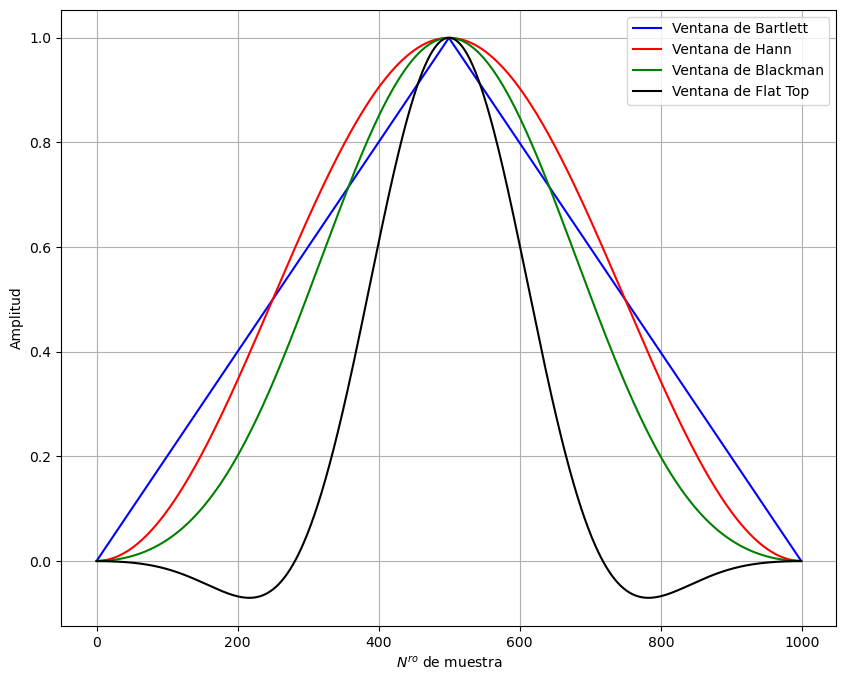

In [60]:
## Genero las ventanas

window_bartlett = np.bartlett(N)
window_hann = sc.signal.windows.hann(N)
window_blackman = np.blackman(N)
window_flat_top = sc.signal.windows.flattop(N)

## Ploteamos las diferentes ventanas
plt.figure(1, figsize = (10,8))
plt.plot(np.arange(N), window_bartlett, "b-",label = "Ventana de Bartlett")
plt.plot(np.arange(N), window_hann    , "r-",label = "Ventana de Hann")
plt.plot(np.arange(N), window_blackman, "g-",label = "Ventana de Blackman")
plt.plot(np.arange(N), window_flat_top, "k-",label = "Ventana de Flat Top")
plt.xlabel(r"$N^{ro}$ de muestra")
plt.ylabel("Amplitud")
plt.grid()
plt.legend()
plt.show()


## ¿Como afectan las ventanas a la estimacion de la amplitud?

Vamos a analizar como cada ventana afecta a la estimacion de la amplitud de la senal, analizando el sesgo, la varianza y la media de la estimacion. Usamos como estimador la amplitud maxima de la FFT.


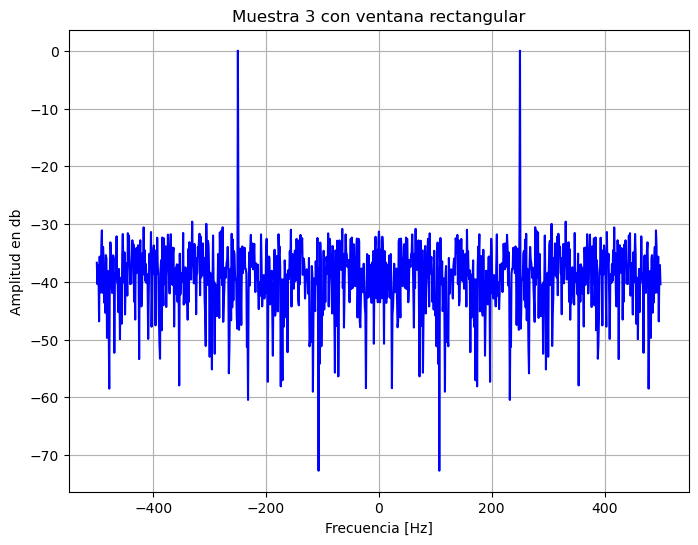



Si estimamos con una ventana rectangular, la media del estimador es de  1.749, con una varianza de  5.105e-02 y sesgo de -2.505e-01




In [61]:
freqs = np.fft.fftfreq(N, d=1/fs)  # Frecuencias normalizadas entre -0.5 y 0.5
freqs_shifted = np.fft.fftshift(freqs)
bins = np.linspace(0,Vp,51)
## Calculamos la fft con la ventana de Rectangular
x_fft_rect = np.fft.fft(x_matrix)/N
plt.figure(2,figsize = (8,6))
plt.plot(freqs_shifted, np.fft.fftshift(20*np.log10(np.abs(x_fft_rect[2,:]))), "b-",)
plt.grid()
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud en db")
plt.title("Muestra 3 con ventana rectangular")
plt.show()


a_est_rect = estimador_amp(x_fft_rect,N,fs)
media_rect = np.mean(a_est_rect)
sesgo_rect = np.mean(a_est_rect) - Vp
var_rect   = np.var(a_est_rect)
rect_hist = np.histogram(a_est_rect)

print(f"\n\nSi estimamos con una ventana rectangular, la media del estimador es de {media_rect: .3f}, con una varianza de {var_rect: .3e}\
 y sesgo de {sesgo_rect: .3e}\n\n")

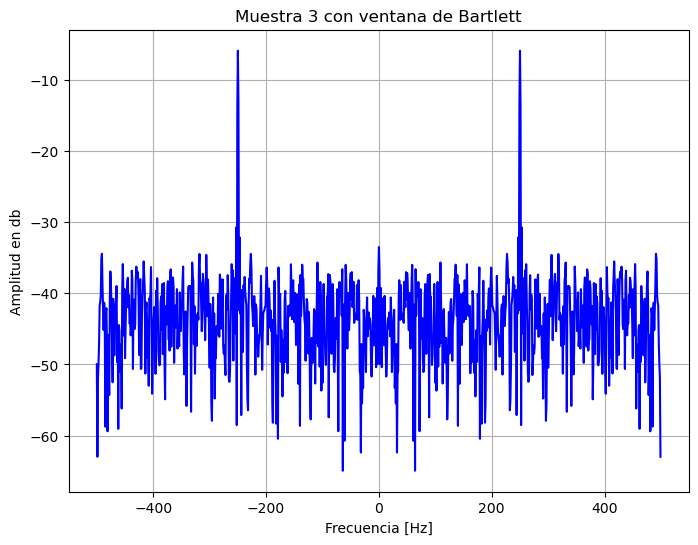



Si estimamos con una ventana de Bartlett, la media del estimador es de  0.935, con una varianza de  3.569e-03 y sesgo de -1.065e+00




In [62]:
## Calculamos la fft con la ventana de Bartlett

x_fft_bartlett = np.fft.fft(x_matrix*np.tile(window_bartlett, (len(fr), 1)))/N
plt.figure(3,figsize = (8,6))
plt.plot(freqs_shifted, np.fft.fftshift(20*np.log10(np.abs(x_fft_bartlett[2,:]))), "b-")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud en db")
plt.title("Muestra 3 con ventana de Bartlett")
plt.grid()
plt.show()

a_est_bartlett = estimador_amp(x_fft_bartlett,N,fs)
media_bartlett = np.mean(a_est_bartlett)
sesgo_bartlett = np.mean(a_est_bartlett) - Vp
var_bartlett   = np.var(a_est_bartlett)
bartlett_hist = np.histogram(a_est_bartlett)

print(f"\n\nSi estimamos con una ventana de Bartlett, la media del estimador es de {media_bartlett: .3f}, con una varianza de {var_bartlett: .3e}\
 y sesgo de {sesgo_bartlett: .3e}\n\n")

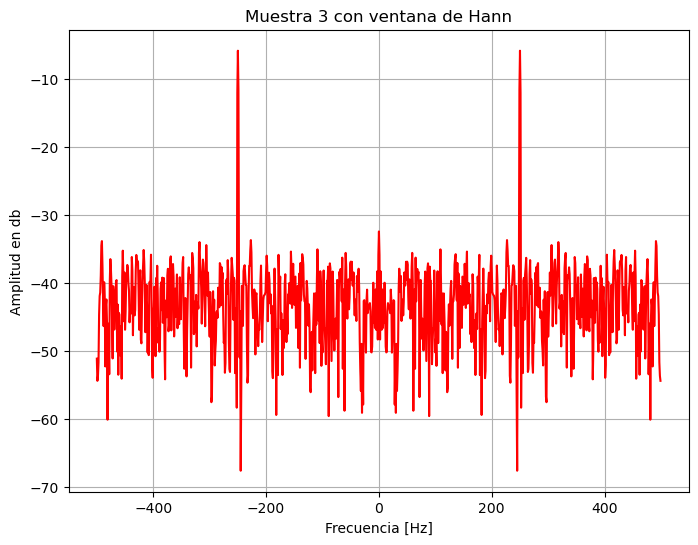



Si estimamos con una ventana de Hann, la media del estimador es de  0.948, con una varianza de  2.347e-03 y sesgo de -1.052e+00




In [63]:
## Calculamos la fft con la ventana de Hann
x_fft_hann = np.fft.fft(x_matrix*np.tile(window_hann, (len(fr), 1)))/N
plt.figure(4, figsize=(8,6))
plt.plot(freqs_shifted, np.fft.fftshift(20*np.log10(np.abs(x_fft_hann[2,:]))), "r-")
plt.xlabel("bins")
plt.grid()
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud en db")
plt.title("Muestra 3 con ventana de Hann")
plt.show()

a_est_hann = estimador_amp(x_fft_hann,N,fs)
media_hann = np.mean(a_est_hann)
sesgo_hann = np.mean(a_est_hann) - Vp
var_hann   = np.var(a_est_hann)
hann_hist = np.histogram(a_est_hann)

print(f"\n\nSi estimamos con una ventana de Hann, la media del estimador es de {media_hann: .3f}, con una varianza de {var_hann: .3e}\
 y sesgo de {sesgo_hann: .3e}\n\n")

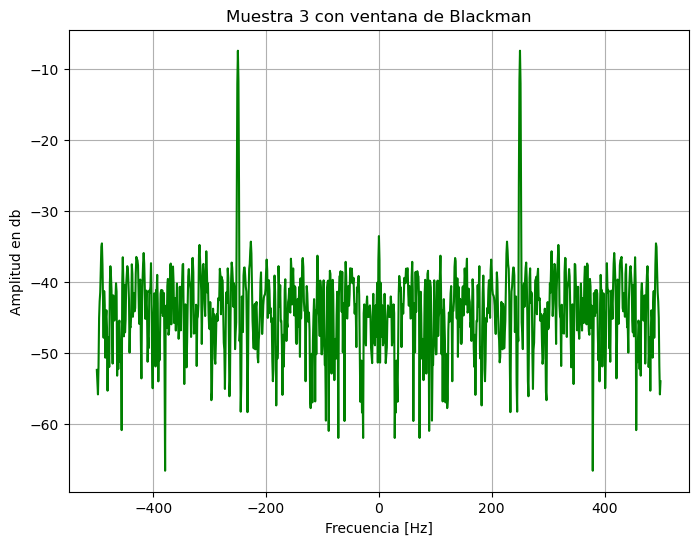



Si estimamos con una ventana de Blackman, la media del estimador es de  0.806, con una varianza de  1.088e-03 y sesgo de -1.194e+00




In [64]:
## Calculamos la fft con la ventana de Blackman
x_fft_blackman = np.fft.fft(x_matrix*np.tile(window_blackman, (len(fr), 1)))/N
plt.figure(5, figsize = (8,6))
plt.plot(freqs_shifted, np.fft.fftshift(20*np.log10(np.abs(x_fft_blackman[2,:]))), "g-")
plt.xlabel("bins")
plt.grid()
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud en db")
plt.title("Muestra 3 con ventana de Blackman")
plt.show()

a_est_blackman = estimador_amp(x_fft_blackman,N,fs)
media_blackman = np.mean(a_est_blackman)
sesgo_blackman = np.mean(a_est_blackman) - Vp
var_blackman   = np.var(a_est_blackman)
blackman_hist = np.histogram(a_est_blackman)

print(f"\n\nSi estimamos con una ventana de Blackman, la media del estimador es de {media_blackman: .3f}, con una varianza de {var_blackman: .3e}\
 y sesgo de {sesgo_blackman: .3e}\n\n")

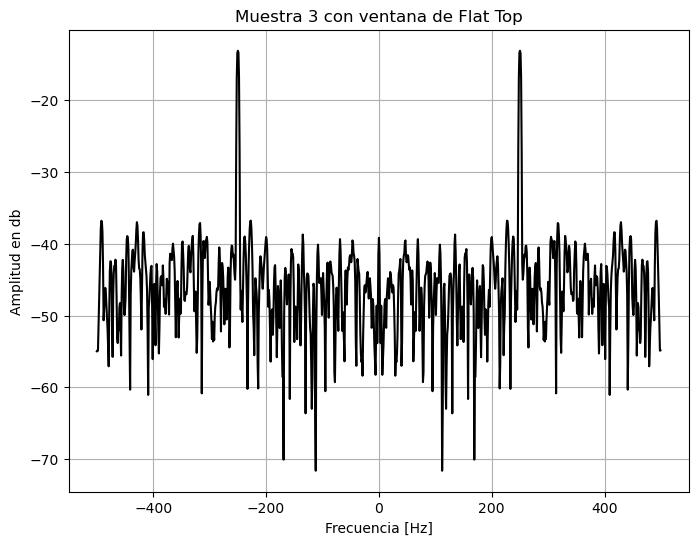



Si estimamos con una ventana Flat Top, la media del estimador es de  0.431, con una varianza de  6.306e-05 y sesgo de -1.569e+00




In [65]:
## Calculamos la fft con la ventana Flat top
x_fft_flattop = np.fft.fft(x_matrix*np.tile(window_flat_top, (len(fr), 1)))/N
plt.figure(6, figsize=(8,6))
plt.plot(freqs_shifted, np.fft.fftshift(20*np.log10(np.abs(x_fft_flattop[2,:]))), "k-")
plt.xlabel("bins")
plt.grid()
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud en db")
plt.title("Muestra 3 con ventana de Flat Top")
plt.show()

a_est_flattop = estimador_amp(x_fft_flattop,N,fs)
media_flattop = np.mean(a_est_flattop)
sesgo_flattop = np.mean(a_est_flattop) - Vp
var_flattop   = np.var(a_est_flattop)
flattop_hist = np.histogram(a_est_flattop,bins)[0]

print(f"\n\nSi estimamos con una ventana Flat Top, la media del estimador es de {media_flattop: .3f}, con una varianza de {var_flattop: .3e}\
 y sesgo de {sesgo_flattop: .3e}\n\n")

## Histogramas de los estimadores

Vamos a analizar los histogramas de los estimadores para luego sacar nuestras conclusiones 

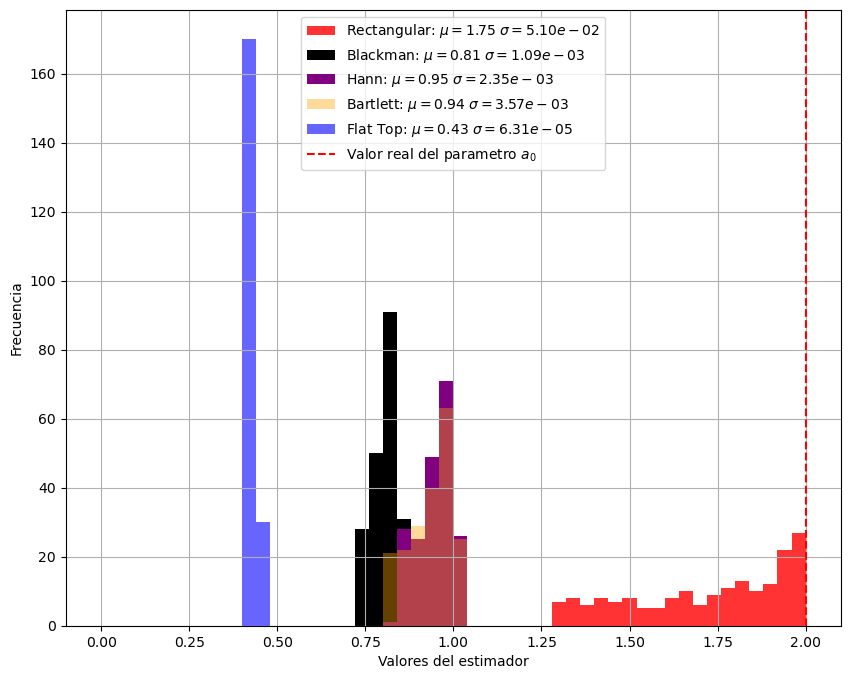

╒═════════════╤═══════════╤═════════════╕
│ Ventana     │     Sesgo │   Varianzas │
╞═════════════╪═══════════╪═════════════╡
│ Rectangular │ -0.250512 │  0.051049   │
├─────────────┼───────────┼─────────────┤
│ Bartlett    │ -1.06484  │  0.0035693  │
├─────────────┼───────────┼─────────────┤
│ Hann        │ -1.05155  │  0.0023475  │
├─────────────┼───────────┼─────────────┤
│ Blackman    │ -1.19399  │  0.0010879  │
├─────────────┼───────────┼─────────────┤
│ Flat Top    │ -1.56856  │  6.3057e-05 │
╘═════════════╧═══════════╧═════════════╛


In [66]:
## Ploteamos los histogramas
plt.figure(7,figsize=(10,8))
plt.hist(a_est_rect     ,bins,color='red'    ,alpha=0.8, label= f"Rectangular: $\mu = {media_rect:.2f}$ $\sigma = {var_rect:.2e}$")
plt.hist(a_est_blackman ,bins,color='black'  ,alpha=1, label= f"Blackman: $\mu = {media_blackman:.2f}$ $\sigma = {var_blackman:.2e}$")
plt.hist(a_est_hann     ,bins,color='purple' ,alpha=1, label= f"Hann: $\mu = {media_hann:.2f}$ $\sigma = {var_hann:.2e}$")
plt.hist(a_est_bartlett ,bins,color='orange' ,alpha=0.4, label= f"Bartlett: $\mu = {media_bartlett:.2f}$ $\sigma = {var_bartlett:.2e}$")
plt.hist(a_est_flattop  ,bins,color ="blue"  ,alpha=0.6, label= f"Flat Top: $\mu = {media_flattop:.2f}$ $\sigma = {var_flattop:.2e}$")
plt.axvline(Vp, linestyle = "dashed",color= "red", label = f"Valor real del parametro $a_0$")
plt.legend()
plt.xlabel("Valores del estimador")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()


datos_tabla = [
    ["Rectangular", sesgo_rect, var_rect],
    ["Bartlett", sesgo_bartlett, var_bartlett],
    ["Hann", sesgo_hann, var_hann],
    ["Blackman", sesgo_blackman, var_blackman],
    ["Flat Top", sesgo_flattop, var_flattop]
]

data_formatted = [
    [Ventana, Sesgo, f"{varianza: .4e}"] 
    for Ventana, Sesgo, varianza in datos_tabla
]

encabezados = ["Ventana", "Sesgo", "Varianzas"]

tabla = tabulate(data_formatted, headers = encabezados, tablefmt="fancy_grid")
print(tabla)


## Conclusion

Viendo el histograma, podemos apreciar que la ventana que menos sesgo introdujo fue la rectangular.

Pero... ¿Es esto importante?

La respuesta es que no, el sesgo es un devio que podemos corregir ya que actua como un offset. Lo que si nos preocupa  es la varianza.

Esto es asi ya que la varianza es una incertidumbre propia de la variable aleatoria, y la ventana rectangular es la que peor varianza presenta, contrario a Flat Top que es la mas sesgada pero de menor varianza, siendo la mejor opcion para estimar la amplitud.

Es decir, para la estimacion lo mas importante es limitar la varianza, ya que esta es propia de la variable aleatoria, pero debo tener en cuenta y ser capaz de corregir el sesgo del estimador